# Task 3 Optimization

In the Binn Packing Problem (BPP) given a collection of items, the goal is to efficiently pack the items into the minimum number of bins, where each item has an associated weight, and the bins have a maximum weight.

#### 1. From Integer Linear Programming (ILP) to Quadratic Unconstrained Binary Optimization (QUBO).



*   Define the ILP formulation of the BPP. You can use Docplex or similar frameworks to do it.



Defining the problem:

Given $n$ number of items with their respective weights ($w_j$, considering $j = 0, ..., n - 1$), we are interested in the best arrangement of the items to minimize the number bins, given $m$ available bins with a certain maximum weight $P$. That is to say that the linear expression of our cost function can be represented as follows:

$$
\underset{x}{\text{min}} f(x) = \underset{x}{\text{min}} \sum _{i = 0} ^{m - 1} x_i.
$$

Where $x_i \in \{ 0, 1 \}$ is the binary variable that represents the $i$-th bin.

The first of our linear constraints makes sure that the item $j$ does not appear two times in our solution, and it can be written as:

$$
\sum_{i=0} ^{m - 1} k_{ij} = 1.
$$

Where $k_{i, j} \in \{0, 1 \}$ is the binary variable that tells us if the $j$-th item is in the $i$-th bin.

The second linear constraint makes sure that the item's weights in the $i$-th bin won't surpass the maximum weight P, and it is defined as follows:

$$
\sum _{j=0} ^{n - 1} w_{j} k_{ij} \leq P x_i.
$$

In [225]:
!pip install docplex
!pip install qiskit_optimization
!pip install cplex
!pip intall qiskit
!pip install qiskit-aer
!pip install qiskit_algorithms
!pip intall dimod
!pip install dwave-system

ERROR: unknown command "intall" - maybe you meant "install"
ERROR: unknown command "intall" - maybe you meant "install"


In [226]:
import numpy as np
from collections import defaultdict
import docplex
import cplex
from docplex.mp.model import Model #Mathematical Programming model
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

In [227]:
# Docplex model
def BPP_model(n, m, w, P):
  # create a Model instance
  model = Model('BPP') # stores all the information of our model

  # define decision variables
  x = model.binary_var_list([f'x{i}' for i in range(m)])
  k = model.binary_var_list([f'k{i},{j}' for i in range(m) for j in range(n)])

  # define constraints
  for j in range(n):
    const_0 = model.sum([k[i * n + j] for i in range(m)])
    model.add_constraint(const_0 == 1)

  for i in range(m):
    const_1 = model.sum([w[j] * k[i * n + j] for j in range(n)])
    model.add_constraint(const_1 <= P * x[i])

  # define linear expressions
  obj_function = model.sum([x[i] for i in range(m)])

  # define objective function
  model.minimize(obj_function)

  # load from Docplex model to QuadraticProgram to make construct an optimization problem
  qp = from_docplex_mp(model)

  return model, qp

*   Create a function to transform the ILP model into a QUBO.

In [228]:
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import CplexOptimizer

def QUBO_BPP(qp):
  # add slack variables to converto from inequality to equality
  ineq2eq = InequalityToEquality()
  qp_eq = ineq2eq.convert(qp)

  # converts the slack variable into its binary representation
  int2bin = IntegerToBinary()
  qp_eq_bin = int2bin.convert(qp_eq)

  # converts linear equality to penalty
  lineq2penalty = LinearEqualityToPenalty()
  qp_eq_bin_pen = lineq2penalty.convert(qp_eq_bin)

  # makes a qubo representation of the binary optimization problem
  conv2= QuadraticProgramToQubo()
  qubo = conv2.convert(qp_eq_bin_pen)

  return qubo

*   Test your function with specific instances (size small, medium, and big)

In [229]:
#Size small
n = 3 # number of items
m = n # number of allowed bins
P = 3 # maximum weight of the bins

w = defaultdict(int) # weights of the items

for j in range(n):
  w[j] = np.random.randint(1, P)
print('weights: ', w)

model, qp = BPP_model(n, m, w, P)
qubo = QUBO_BPP(qp)
print(qubo.prettyprint())

weights:  defaultdict(<class 'int'>, {0: 1, 1: 2, 2: 1})
Problem name: BPP

Minimize
  4*c3@int_slack@0^2 + 16*c3@int_slack@0*c3@int_slack@1 + 16*c3@int_slack@1^2
  + 4*c4@int_slack@0^2 + 16*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@1^2
  + 4*c5@int_slack@0^2 + 16*c5@int_slack@0*c5@int_slack@1 + 16*c5@int_slack@1^2
  + 8*k0,0*c3@int_slack@0 + 16*k0,0*c3@int_slack@1 + 8*k0,0^2 + 16*k0,0*k0,1
  + 8*k0,0*k0,2 + 8*k0,0*k1,0 + 8*k0,0*k2,0 + 16*k0,1*c3@int_slack@0
  + 32*k0,1*c3@int_slack@1 + 20*k0,1^2 + 16*k0,1*k0,2 + 8*k0,1*k1,1
  + 8*k0,1*k2,1 + 8*k0,2*c3@int_slack@0 + 16*k0,2*c3@int_slack@1 + 8*k0,2^2
  + 8*k0,2*k1,2 + 8*k0,2*k2,2 + 8*k1,0*c4@int_slack@0 + 16*k1,0*c4@int_slack@1
  + 8*k1,0^2 + 16*k1,0*k1,1 + 8*k1,0*k1,2 + 8*k1,0*k2,0 + 16*k1,1*c4@int_slack@0
  + 32*k1,1*c4@int_slack@1 + 20*k1,1^2 + 16*k1,1*k1,2 + 8*k1,1*k2,1
  + 8*k1,2*c4@int_slack@0 + 16*k1,2*c4@int_slack@1 + 8*k1,2^2 + 8*k1,2*k2,2
  + 8*k2,0*c5@int_slack@0 + 16*k2,0*c5@int_slack@1 + 8*k2,0^2 + 16*k2,0*k2,1
  + 8*

In [230]:
#Size medium
n = 3 # number of items
m = n # number of allowed bins
P = 7 # maximum weight of the bins
w = defaultdict(int) # weights of the items

for j in range(n):
  w[j] = np.random.randint(1, P)
print('weights: ', w)

model, qp = BPP_model(n, m, w, P)
qubo = QUBO_BPP(qp)
print(qubo.prettyprint())

weights:  defaultdict(<class 'int'>, {0: 6, 1: 1, 2: 3})
Problem name: BPP

Minimize
  4*c3@int_slack@0^2 + 16*c3@int_slack@0*c3@int_slack@1
  + 32*c3@int_slack@0*c3@int_slack@2 + 16*c3@int_slack@1^2
  + 64*c3@int_slack@1*c3@int_slack@2 + 64*c3@int_slack@2^2 + 4*c4@int_slack@0^2
  + 16*c4@int_slack@0*c4@int_slack@1 + 32*c4@int_slack@0*c4@int_slack@2
  + 16*c4@int_slack@1^2 + 64*c4@int_slack@1*c4@int_slack@2 + 64*c4@int_slack@2^2
  + 4*c5@int_slack@0^2 + 16*c5@int_slack@0*c5@int_slack@1
  + 32*c5@int_slack@0*c5@int_slack@2 + 16*c5@int_slack@1^2
  + 64*c5@int_slack@1*c5@int_slack@2 + 64*c5@int_slack@2^2
  + 48*k0,0*c3@int_slack@0 + 96*k0,0*c3@int_slack@1 + 192*k0,0*c3@int_slack@2
  + 148*k0,0^2 + 48*k0,0*k0,1 + 144*k0,0*k0,2 + 8*k0,0*k1,0 + 8*k0,0*k2,0
  + 8*k0,1*c3@int_slack@0 + 16*k0,1*c3@int_slack@1 + 32*k0,1*c3@int_slack@2
  + 8*k0,1^2 + 24*k0,1*k0,2 + 8*k0,1*k1,1 + 8*k0,1*k2,1 + 24*k0,2*c3@int_slack@0
  + 48*k0,2*c3@int_slack@1 + 96*k0,2*c3@int_slack@2 + 40*k0,2^2 + 8*k0,2*k1,2
  + 

In [231]:
#Big medium
n = 5 # number of items
m = n # number of allowed bins
P = 12 # maximum weight of the bins
w = defaultdict(int) # weights of the items

for j in range(n):
  w[j] = np.random.randint(1, P)
print('weights: ', w)

model, qp = BPP_model(n, m, w, P)
qubo = QUBO_BPP(qp)
print(qubo.prettyprint())

weights:  defaultdict(<class 'int'>, {0: 11, 1: 9, 2: 8, 3: 8, 4: 5})
Problem name: BPP

Minimize
  6*c5@int_slack@0^2 + 24*c5@int_slack@0*c5@int_slack@1
  + 48*c5@int_slack@0*c5@int_slack@2 + 60*c5@int_slack@0*c5@int_slack@3
  + 24*c5@int_slack@1^2 + 96*c5@int_slack@1*c5@int_slack@2
  + 120*c5@int_slack@1*c5@int_slack@3 + 96*c5@int_slack@2^2
  + 240*c5@int_slack@2*c5@int_slack@3 + 150*c5@int_slack@3^2
  + 6*c6@int_slack@0^2 + 24*c6@int_slack@0*c6@int_slack@1
  + 48*c6@int_slack@0*c6@int_slack@2 + 60*c6@int_slack@0*c6@int_slack@3
  + 24*c6@int_slack@1^2 + 96*c6@int_slack@1*c6@int_slack@2
  + 120*c6@int_slack@1*c6@int_slack@3 + 96*c6@int_slack@2^2
  + 240*c6@int_slack@2*c6@int_slack@3 + 150*c6@int_slack@3^2
  + 6*c7@int_slack@0^2 + 24*c7@int_slack@0*c7@int_slack@1
  + 48*c7@int_slack@0*c7@int_slack@2 + 60*c7@int_slack@0*c7@int_slack@3
  + 24*c7@int_slack@1^2 + 96*c7@int_slack@1*c7@int_slack@2
  + 120*c7@int_slack@1*c7@int_slack@3 + 96*c7@int_slack@2^2
  + 240*c7@int_slack@2*c7@int_slack

#### 2. Create a Brute Force solver for the QUBO problem and solve the specific instances.

In [232]:
def BF_QUBO(qubo):
  # solves the qubo using
  sol_qubo = CplexOptimizer().solve(qubo)
  return sol_qubo

#### 3. To solve the QUBO, use quantum annealing simulators. You can use Dwave Ocean Framework.

In [233]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
import pandas as pd
import matplotlib.pyplot as plt

def QA(num_bin_var, qubo):
  bqm = dimod.as_bqm(qubo.objective.linear.to_array(), qubo.objective.quadratic.to_array(), dimod.BINARY)

  # Define the sampler
  sampler = SimulatedAnnealingSampler()

  # Sample the BQM and store the results in the SampleSet object
  sampleset = sampler.sample(bqm, num_reads = 1024)

  df = sampleset.to_pandas_dataframe().sort_values('energy')

  samples_dwave = defaultdict(int)

  for i, row in df.iterrows():
    sample_i = ''.join(str(round(row[q])) for q in range(num_bin_var))
    samples_dwave[sample_i] += int(row['num_occurrences'])

  return samples_dwave

#### 4. Use a quantum variational approach to solve the QUBO.



*   Create multiple Ansantz for testing.


In [234]:
from qiskit.circuit.library import TwoLocal

def Ansantz_1(num_qubits):
  return TwoLocal(num_qubits, 'ry', 'cz')

def Ansantz_2(num_qubits):
  return TwoLocal(num_qubits, 'rx', 'cz')

def Ansantz_3(num_qubits):
  return TwoLocal(num_qubits, 'h', 'crz')

*   Build a function with input being the QUBO and Ansantz. Using a hybrid approach solved the QUBO.

In [235]:
from qiskit_algorithms import SamplingVQE
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

def VQE_BPP(qubo, ansantz):
  bqm = dimod.as_bqm(qubo.objective.linear.to_array(), qubo.objective.quadratic.to_array(), dimod.BINARY)
  # solves the qubo using VQE
  vqe = MinimumEigenOptimizer(SamplingVQE(sampler = Sampler(), ansatz = ansantz, optimizer=COBYLA(maxiter=10)))

  return vqe.solve(qp)

#### 5. Use QAOA to solve the QUBO.

In [236]:
from qiskit.primitives import Sampler
from qiskit_algorithms import QAOA

def QAOA_BPP(qubo):
  # solves the qubo using QAOA
  qaoa = MinimumEigenOptimizer(QAOA(sampler = Sampler(), optimizer=COBYLA(maxiter=10)))

  return qaoa.solve(qp)

#### 6. Compare and analyze the results.

Let consider a small instance of three bins (n=3) and three elements (m=3) with random weights and a maximum weight of each bin of three (P=3).

In [237]:
n = 3 # number of items
m = n # number of allowed bins
P = 3 # maximum weight of the bins

w = defaultdict(int) # weights of the items

for j in range(n):
  w[j] = np.random.randint(1, P)
print('weights: ', w)

weights:  defaultdict(<class 'int'>, {0: 2, 1: 1, 2: 2})


In [238]:
# BPP Model
model, qp = BPP_model(n, m, w, P)

print(qp.prettyprint())

Problem name: BPP

Minimize
  x0 + x1 + x2

Subject to
  Linear constraints (6)
    k0,0 + k1,0 + k2,0 == 1  'c0'
    k0,1 + k1,1 + k2,1 == 1  'c1'
    k0,2 + k1,2 + k2,2 == 1  'c2'
    2*k0,0 + k0,1 + 2*k0,2 - 3*x0 <= 0  'c3'
    2*k1,0 + k1,1 + 2*k1,2 - 3*x1 <= 0  'c4'
    2*k2,0 + k2,1 + 2*k2,2 - 3*x2 <= 0  'c5'

  Binary variables (12)
    x0 x1 x2 k0,0 k0,1 k0,2 k1,0 k1,1 k1,2 k2,0 k2,1 k2,2



*   QUBO brute force

In [239]:
qubo = QUBO_BPP(qp)
print(qubo.prettyprint())

Problem name: BPP

Minimize
  4*c3@int_slack@0^2 + 16*c3@int_slack@0*c3@int_slack@1 + 16*c3@int_slack@1^2
  + 4*c4@int_slack@0^2 + 16*c4@int_slack@0*c4@int_slack@1 + 16*c4@int_slack@1^2
  + 4*c5@int_slack@0^2 + 16*c5@int_slack@0*c5@int_slack@1 + 16*c5@int_slack@1^2
  + 16*k0,0*c3@int_slack@0 + 32*k0,0*c3@int_slack@1 + 20*k0,0^2 + 16*k0,0*k0,1
  + 32*k0,0*k0,2 + 8*k0,0*k1,0 + 8*k0,0*k2,0 + 8*k0,1*c3@int_slack@0
  + 16*k0,1*c3@int_slack@1 + 8*k0,1^2 + 16*k0,1*k0,2 + 8*k0,1*k1,1 + 8*k0,1*k2,1
  + 16*k0,2*c3@int_slack@0 + 32*k0,2*c3@int_slack@1 + 20*k0,2^2 + 8*k0,2*k1,2
  + 8*k0,2*k2,2 + 16*k1,0*c4@int_slack@0 + 32*k1,0*c4@int_slack@1 + 20*k1,0^2
  + 16*k1,0*k1,1 + 32*k1,0*k1,2 + 8*k1,0*k2,0 + 8*k1,1*c4@int_slack@0
  + 16*k1,1*c4@int_slack@1 + 8*k1,1^2 + 16*k1,1*k1,2 + 8*k1,1*k2,1
  + 16*k1,2*c4@int_slack@0 + 32*k1,2*c4@int_slack@1 + 20*k1,2^2 + 8*k1,2*k2,2
  + 16*k2,0*c5@int_slack@0 + 32*k2,0*c5@int_slack@1 + 20*k2,0^2 + 16*k2,0*k2,1
  + 32*k2,0*k2,2 + 8*k2,1*c5@int_slack@0 + 16*k2,1*c5@i

In [240]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sol(solution, n, m, P, title):
  items = defaultdict(int)
  for item in range(n):
    items[f'item {item + 1}'] = np.zeros(m)

  for bin in range(m):
    for item in range(n):
      if solution[bin] == '1' and solution[m + n * bin + item] == '1':
        items[f'item {item + 1}'][bin] = w[item]

  plotdata = pd.DataFrame(items, index = [i for i in range(1, n + 1)])
  plotdata.plot(kind='bar', stacked=True, figsize=(4, 3))
  plt.hlines(P,0-0.5,m-0.5,linestyle="--", color="r",label="Max W")
  plt.title(title)
  plt.xlabel('Bins')
  plt.ylabel('Weights')
  plt.legend()
  plt.show()

Brute force solution of the QUBO: 
objective function value: 2.0
variable values: x0=0.0, x1=1.0, x2=1.0, k0,0=0.0, k0,1=0.0, k0,2=0.0, k1,0=1.0, k1,1=1.0, k1,2=0.0, k2,0=0.0, k2,1=0.0, k2,2=1.0, c3@int_slack@0=0.0, c3@int_slack@1=0.0, c4@int_slack@0=0.0, c4@int_slack@1=0.0, c5@int_slack@0=1.0, c5@int_slack@1=0.0
status: SUCCESS


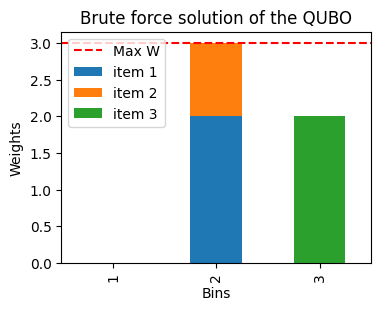

In [262]:
# Brute force solution of the QUBO
num_bin_var = len(qp.variables)

sol_qubo = BF_QUBO(qubo)

print('Brute force solution of the QUBO: ')
print(sol_qubo.prettyprint())

bf_sol = ''.join(str(round(sol_qubo[q])) for q in range(num_bin_var))

plot_sol(bf_sol, n, m, P, 'Brute force solution of the QUBO')

*   Quantum Annealing

Solution of the BPP using QA:  110011100000


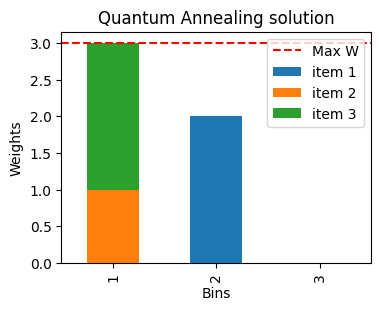

In [263]:
# Quantum Annealing solution
samples_dwave = QA(num_bin_var, qubo)

sol_qa = max(samples_dwave, key=samples_dwave.get)

print('Solution of the BPP using QA: ', sol_qa)

plot_sol(sol_qa, n, m, P, 'Quantum Annealing solution')

*   Quantum Variational

<ipython-input-235-e20092e85c70>:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = MinimumEigenOptimizer(SamplingVQE(sampler = Sampler(), ansatz = ansantz, optimizer=COBYLA(maxiter=10)))


Solution of the BPP using VQE using ansantz 1: 
objective function value: 2.0
variable values: x0=0.0, x1=1.0, x2=1.0, k0,0=0.0, k0,1=0.0, k0,2=0.0, k1,0=0.0, k1,1=1.0, k1,2=1.0, k2,0=1.0, k2,1=0.0, k2,2=0.0
status: SUCCESS


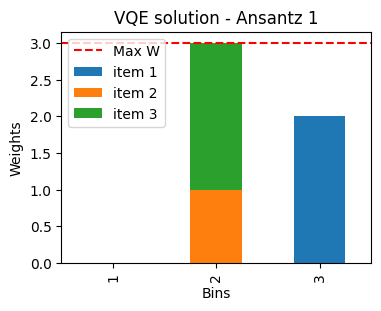

In [243]:
num_qubits = len(qubo.variables)

# VQE solution - Ansantz 1
ansantz = Ansantz_1(num_qubits)

result_vqe_1 = VQE_BPP(qubo, ansantz)

print('Solution of the BPP using VQE using ansantz 1: ')
print(result_vqe_1.prettyprint())

sol_vqe_1 = ''.join(str(round(i)) for i in result_vqe_1)

plot_sol(sol_vqe_1, n, m, P, 'VQE solution - Ansantz 1')

<ipython-input-235-e20092e85c70>:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = MinimumEigenOptimizer(SamplingVQE(sampler = Sampler(), ansatz = ansantz, optimizer=COBYLA(maxiter=10)))


Solution of the BPP using VQE using ansantz 2: 
objective function value: 2.0
variable values: x0=1.0, x1=1.0, x2=0.0, k0,0=0.0, k0,1=0.0, k0,2=1.0, k1,0=1.0, k1,1=1.0, k1,2=0.0, k2,0=0.0, k2,1=0.0, k2,2=0.0
status: SUCCESS


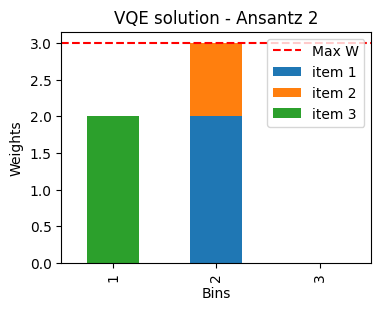

In [244]:
# VQE solution - Ansantz 2
ansantz = Ansantz_2(num_qubits)

result_vqe_2 = VQE_BPP(qubo, ansantz)

print('Solution of the BPP using VQE using ansantz 2: ')
print(result_vqe_2.prettyprint())

sol_vqe_2 = ''.join(str(round(i)) for i in result_vqe_2)

plot_sol(sol_vqe_2, n, m, P, 'VQE solution - Ansantz 2')

<ipython-input-235-e20092e85c70>:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = MinimumEigenOptimizer(SamplingVQE(sampler = Sampler(), ansatz = ansantz, optimizer=COBYLA(maxiter=10)))


Solution of the BPP using VQE using ansantz 3: 
objective function value: 2.0
variable values: x0=1.0, x1=1.0, x2=0.0, k0,0=0.0, k0,1=0.0, k0,2=1.0, k1,0=1.0, k1,1=1.0, k1,2=0.0, k2,0=0.0, k2,1=0.0, k2,2=0.0
status: SUCCESS


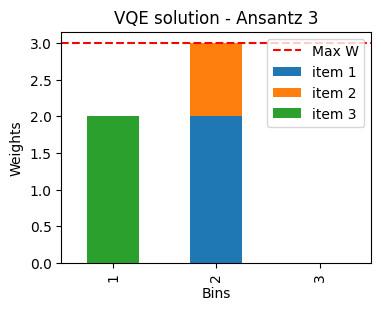

In [245]:
# VQE solution - Ansantz 3
ansantz = Ansantz_3(num_qubits)

result_vqe_3 = VQE_BPP(qubo, ansantz)

print('Solution of the BPP using VQE using ansantz 3: ')
print(result_vqe_3.prettyprint())

sol_vqe_3 = ''.join(str(round(i)) for i in result_vqe_3)

plot_sol(sol_vqe_3, n, m, P, 'VQE solution - Ansantz 3')

*   QAOA

<ipython-input-236-64fbc9d62bb4>:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa = MinimumEigenOptimizer(QAOA(sampler = Sampler(), optimizer=COBYLA(maxiter=10)))


Solution of the BPP using QAOA: 
objective function value: 2.0
variable values: x0=1.0, x1=1.0, x2=0.0, k0,0=0.0, k0,1=0.0, k0,2=1.0, k1,0=1.0, k1,1=1.0, k1,2=0.0, k2,0=0.0, k2,1=0.0, k2,2=0.0
status: SUCCESS


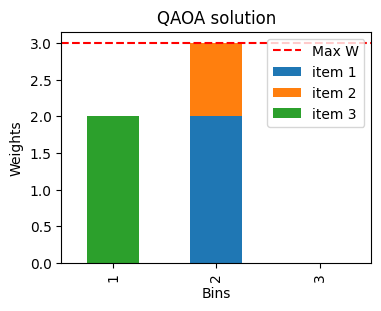

In [246]:
result_qaoa = QAOA_BPP(qubo)

print('Solution of the BPP using QAOA: ')
print(result_qaoa.prettyprint())

sol_qaoa = ''.join(str(round(i)) for i in result_qaoa)

plot_sol(sol_qaoa, n, m, P, 'QAOA solution')

#### Result comparison

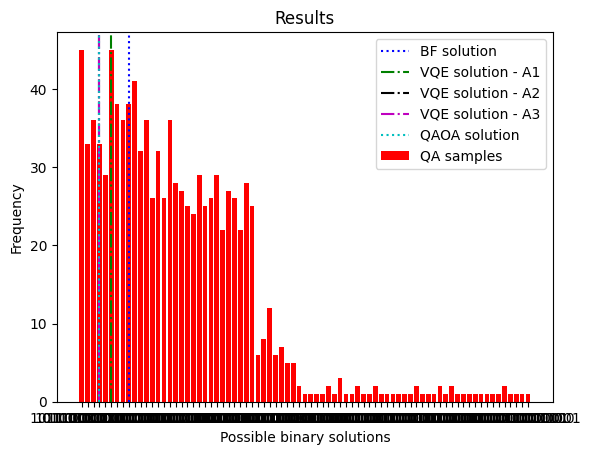

In [261]:
sols = []
vals = []

for i, j in samples_dwave.items():
  sols.append(i)
  vals.append(j)

plt.bar(sols, vals, color='r', label = 'QA samples')
plt.axvline(x = bf_sol, color = 'b', label = 'BF solution', linestyle = ':')
plt.axvline(x = sol_vqe_1, color = 'g', label = 'VQE solution - A1', linestyle = '-.')
plt.axvline(x = sol_vqe_2, color = 'k', label = 'VQE solution - A2', linestyle = '-.')
plt.axvline(x = sol_vqe_3, color = 'm', label = 'VQE solution - A3', linestyle = '-.')
plt.axvline(x = sol_qaoa, color = 'c', label = 'QAOA solution', linestyle = ':')
plt.title('Results')
plt.ylabel('Frequency')
plt.xlabel('Possible binary solutions')
plt.legend()
plt.show()

A small instance of the Bin Packing Problem (BPP) was utilized to compare the results obtained from various classical methods, such as brute force, alongside quantum approaches, including Quantum Annealing (QA), Variational Quantum Eigensolver (VQE), and Quantum Approximation Optimization Algorithm (QAOA). Slack variables served as a penalization method within the QUBO formulation of the BPP. Specifically, three different ansätze (RY and CZ, RX and CZ, Hadamard and CRZ) were proposed to facilitate the comparison of results. These ansätze aim to initialize states that generate combinations of possible solutions, which are then mixed to explore different configurations.

However, VQE simulations required more computational resources, particularly RAM, compared to the other methods employed, with QAOA, QA, and brute force following in resource intensity. Consequently, a smaller instance was selected for evaluating the performance of these algorithms. Future research could explore larger instances using alternative penalization methods, such as unbalanced penalization, to reduce the number of qubits associated with slack variables.

The various graphs illustrating the results reveal many equivalent valid solutions, where the capacity of each bin is not exceeded by the sum of the weights of the items it contains, while also minimizing the total number of bins. These solutions differ primarily in how items are distributed among the bins.

As depicted in the figure above, the solution derived from QAOA aligns with the solutions obtained from the VQE algorithm using Ansätze 2 and 3 for this specific instance. Additionally, the VQE solution from Ansatz 1 corresponds to one of the more frequent outcomes produced by QA, whereas the brute force result, while not matching any solutions from the quantum algorithms, remains a valid solution.

# References

#### BPP

*   https://arxiv.org/abs/2211.13914


#### DOcplex

*   https://qiskit-community.github.io/qiskit-optimization/locale/es_UN/tutorials/01_quadratic_program.html
*   https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.optimization.QuadraticProgram
*   https://github.com/qiskit-community/qiskit-optimization/blob/main/docs/tutorials/02_converters_for_quadratic_programs.ipynb
*   https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/mp/jupyter/tutorials/Linear_Programming.ipynb





#### QUBO

*   https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.converters.QuadraticProgramToQubo.html



#### DWave

*   https://github.com/dwavesystems/dwave-qiskit-plugin
*   https://quantumcomputing.stackexchange.com/questions/16622/from-qiskit-quadraticprogram-to-problem-model-accepted-by-dwave-ocean
*   https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generated/dimod.binary.as_bqm.html
*   https://docs.ocean.dwavesys.com/en/stable/docs_samplers/index.html#simulated-annealing
*   https://pennylane.ai/qml/demos/tutorial_QUBO/
*   https://www.dwavesys.com/media/fmtj2fw3/20210920_ofbguide.pdf
*   https://pyqubo.readthedocs.io/en/latest/reference/model.html


#### VQE

*   https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.SamplingVQE.html#qiskit_algorithms.SamplingVQE
*   https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/vqe-molecules.ipynb
*   https://qiskit-community.github.io/qiskit-algorithms/tutorials/01_algorithms_introduction.html#
*   https://medium.com/qiskit/a-guide-to-the-qiskit-circuit-library-36ee0f189956
*   https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/01_algorithms_introduction.ipynb
*   https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver


#### Anzat

*   https://pennylane.ai/qml/glossary/circuit_ansatz/

#### QAOA
*   https://qiskit-community.github.io/qiskit-optimization/locale/es_UN/tutorials/10_warm_start_qaoa.html
*   https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html#qiskit_algorithms.QAOA
*   https://qiskit-community.github.io/qiskit-optimization/locale/es_UN/tutorials/11_using_classical_optimization_solvers_and_models.html